In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Menetapkan perangkat TensorFlow ke CPU
tf.config.set_visible_devices([], 'GPU')

## **Baca Dataset**




In [15]:
# Path ke folder dataset
dataset_path = '/content/drive/My Drive/Colab Notebooks/deteksi_katarak/dataset'  # Ganti dengan path dataset Anda
normal_path = os.path.join(dataset_path, '1_normal')
cataract_path = os.path.join(dataset_path, '2_cataract')


#**Mempersiapkan Data Dengan ImageGenerator**



## Augmentasi dan preprocessing data untuk pelatihan




In [16]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Menggunakan 20% data untuk validasi
)


## Generator untuk data pelatihan



In [17]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Hanya menggunakan subset training
)

Found 481 images belonging to 4 classes.


## Generator untuk data validasi


In [18]:
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Hanya menggunakan subset validation
)

Found 120 images belonging to 4 classes.


In [19]:
# Menampilkan beberapa gambar dari dataset
def show_sample_images(generator, class_names, n_samples=5):
    sample_images, sample_labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(sample_images[i])
        plt.title(f"Label: {class_names[int(sample_labels[i])]}")
        plt.axis('off')
    plt.show()

In [20]:
# Nama kelas dari generator
class_names = list(train_generator.class_indices.keys())


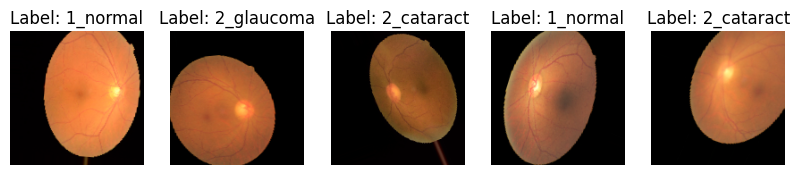

In [21]:
# Menampilkan 5 sampel gambar dari training set
show_sample_images(train_generator, class_names)

## Membangun Arsitektur Model CNN

### model CNN dengan beberapa lapisan konvolusi, pooling, dan dense.



In [22]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
from tensorflow.keras.optimizers import Adam

# Buat optimizer dengan learning rate yang ditentukan
optimizer = Adam(learning_rate=0.01)

# Compile model dengan optimizer yang telah disesuaikan
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 74, 74, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                      

##Callbacks

### EarlyStopping dan ModelCheckpoint untuk menghentikan pelatihan lebih awal jika model tidak membaik dan untuk menyimpan model terbaik.



In [23]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

##Train Model



In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 23.4755 - accuracy: 0.2071 
Epoch 1: val_loss improved from inf to -42.38969, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 287s 19s/step - loss: 23.4755 - accuracy: 0.2071 - val_loss: -42.3897 - val_accuracy: 0.1458
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: -195.7438 - accuracy: 0.1849
Epoch 2: val_loss improved from -42.38969 to -552.37982, saving model to best_model.h5
15/15 [==============================] - 82s 6s/step - loss: -195.7438 - accuracy: 0.1849 - val_loss: -552.3798 - val_accuracy: 0.1667
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: -3.1985 - accuracy: 0.1670 
Epoch 3: val_loss did not improve from -552.37982
15/15 [==============================] - 86s 6s/step - loss: -3.1985 - accuracy: 0.1670 - val_loss: -197.2836 - val_accuracy: 0.1771
Epoch 4/5
15/15 [==============================] - ETA: 0s - loss: -995.6661 - accuracy: 0.1648
Epoch 4: val_loss improved from -552.37982 to -1295.30078, saving model to best_model.h5
15/15 [==============================] - 83s 5s/step - loss: -995.6661 - accuracy: 0.

### Evaluasi model

###Evaluasi model menggunakan data validasi dan plot hasil untuk visualisasi kinerja model

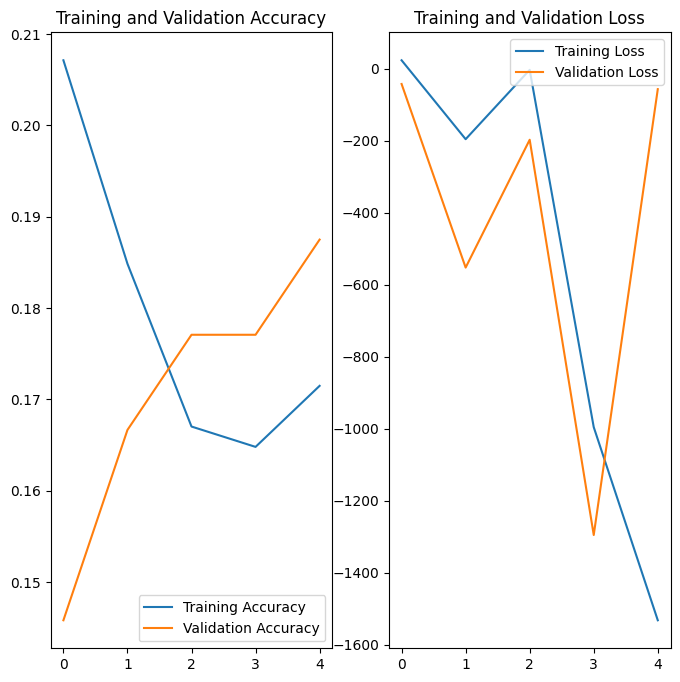

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


##Save Model

In [26]:
# Menyimpan model terakhir
model.save('final_model.h5')

## Uji Coba Model Dengan Prediksi

In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(img_path, model):
    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi

    # Prediksi dengan model
    prediction = model.predict(img_array)

    # Menentukan label berdasarkan prediksi
    label = 'Cataract' if prediction[0] < 0.5 else 'Normal'

    # Menampilkan gambar dengan prediksi
    plt.figure(figsize=(6, 6))
    plt.imshow(image.load_img(img_path))
    plt.title(f'Predicted: {label}')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 141ms/step


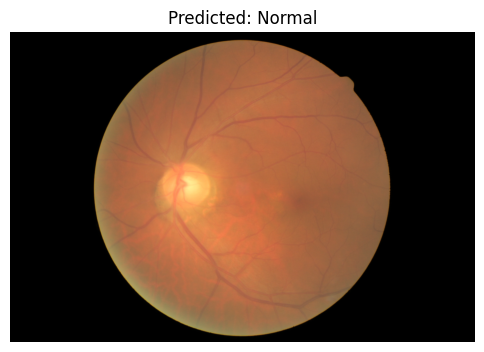

In [28]:
# Contoh penggunaan
predict_image('/content/drive/My Drive/Colab Notebooks/deteksi_katarak/dataset/2_cataract/cataract_001.png', model)

1/1 [==============================] - 0s 30ms/step


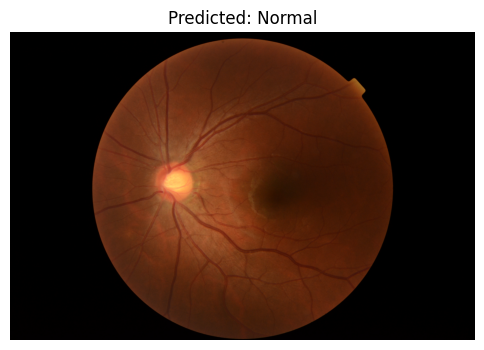

In [29]:
# Contoh penggunaan
predict_image('/content/drive/My Drive/Colab Notebooks/deteksi_katarak/dataset/1_normal/NL_001.png', model)


# Penjelasan dan Keterangan:
###ImageDataGenerator digunakan untuk melakukan augmentasi data yang akan membantu model dalam mengenali pola yang lebih bervariasi dari dataset.
###flow_from_directory adalah metode yang membaca gambar dari direktori yang terorganisir dalam subfolder sesuai dengan label kelas mereka.
###Conv2D, MaxPooling2D, Flatten, Dense, Dropout adalah lapisan-lapisan dari CNN yang membentuk arsitektur model untuk menangani gambar.
###Adam adalah optimizer yang sering digunakan dalam pelatihan jaringan saraf karena efisiensinya.
###loss='binary_crossentropy' digunakan karena ini adalah masalah klasifikasi biner.

###Impor BatchNormalization: Memastikan bahwa BatchNormalization diimpor dari tensorflow.keras.layers.
###show_sample_images: Fungsi ini menampilkan beberapa contoh gambar dari generator untuk memeriksa apakah dataset dimuat dengan benar.
###Sequential Model: Model yang terdiri dari beberapa lapisan konvolusi, batch normalization, max pooling, dan dense.
###callbacks: Menggunakan early stopping untuk menghentikan pelatihan jika model tidak lagi membaik, dan model checkpoint untuk menyimpan model terbaik berdasarkan performa pada data validasi.

